Небольшой проект, в результате которого мы получим программу, которая могла бы находить из нашего датасета "похожие" изображения на изображение, url которого задаст пользователь.
Датасеты: 

data_start: https://drive.google.com/file/d/1f-ptAQlpljc0MvVgOnJsp9Yy_7QM5CT1/view?usp=sharing 

data_lamps: https://drive.google.com/file/d/12M4jg8WuunRRRjT7_0_o6QrAAbBpzKKz/view?usp=sharing

In [18]:
from google.colab import drive 
from zipfile import ZipFile

drive.mount('/content/gdrive', force_remount=True)
!cp -r /content/gdrive/'My Drive'/data_lamps.zip .

Mounted at /content/gdrive


In [19]:
path = 'data_lamps'
with ZipFile(path + '.zip', 'r') as zipfile:
  zipfile.extractall()
  print('Done')

Done


In [26]:
import os
from glob import glob
import numpy as np
import scipy.sparse as sp
from keras.applications import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.engine import Model
from keras.preprocessing import image
from tqdm import tqdm
import random
import cv2
from matplotlib import pyplot as plt
import PIL
import requests
import io
import urllib.request
import tqdm

Обе модели будут работать похожим образом, в некоторых моментах лучше первая, в некоторых вторая. Но, как мне кажется, вторая срезка в среднем даёт более "ожидаемый" результат, особенно когда мы хотим распознать какой-то паттерн на картинке. Например, она лучше находит венчики на миксерах, если в таргет загружен венчик и т.д. + у неё вектор полученных фич поменьше, поэтому просчёты будут немного быстрее.

In [ ]:
model = VGG19(weights='imagenet', include_top=False)
n_dims = 25088

80142336/80134624 [==============================] - 8s 0us/step


In [6]:
mod = VGG19(weights='imagenet')
model = Model(inputs=mod.input, outputs=mod.get_layer('fc1').output)
n_dims = 4096

574717952/574710816 [==============================] - 20s 0us/step


Функция для векторизации всех наших картинок в папке с помощью выбранной модели. Делать это будем по батчам.

In [7]:
def imgs_to_vector(path, model, batch_size=64):
    files = glob(os.path.join(path, '*'))
    size_img = 224
    min_id = 0
    max_id = min(batch_size, len(files))
    predicts = np.empty([len(files), n_dims]) 
    
    while min_id < max_id:
        X = []
        for i in range(min_id, max_id):
            file = files[i]
            img = image.load_img(file, target_size=(size_img, size_img))
            img_array = image.img_to_array(img)
            X.append(img_array)
        max_id= i + 1
        X = np.array(X)
        X = preprocess_input(X)
        shape = ((max_id - min_id), n_dims)
        predicts[min_id:max_id, :] = model.predict(X).reshape(shape)
        min_id = max_id
        max_id = np.min((max_id + batch_size, len(files)))
    return predicts

Векторизуем загруженное изображение и ищем наиболее "похожие" вектора. В качестве метрики выбрана косинусная метрика.

In [31]:
from sklearn.neighbors import NearestNeighbors

def find_similar(URL, path, vecs, n_imgs):
    knn = NearestNeighbors(metric='cosine') #euclidean
    knn.fit(vecs)

    X = []

    response = requests.get(URL)
    image_bytes = io.BytesIO(response.content)
    img_target = PIL.Image.open(image_bytes)

    img_target_resize = img_target.resize((224, 224))

    #with urllib.request.urlopen(URL) as url:
    #  img_target_resize = image.load_img(BytesIO(url.read()), target_size=(224, 224))

    img_array = image.img_to_array(img_target_resize)
    X.append(img_array)
    X = np.array(X)
    X = preprocess_input(X)
    shape = (1, n_dims)
    predict = model.predict(X).reshape(shape)

    vec = predict.reshape(1, -1)
    dists, indices = knn.kneighbors(vec, n_neighbors = min(n_imgs, len(vecs)))
    
    files = glob(os.path.join(path, '*'))
    print("selected image: ")

    response = requests.get(URL)
    image_bytes = io.BytesIO(response.content)
    img_target = PIL.Image.open(image_bytes)
    
    plt.imshow(img_target)
    plt.show()

    print("similar images: ")
    for id, dist in zip(indices[0], dists[0]):
        print(dist)
        img = cv2.imread(files[id])[:, :, ::-1] #эта штука в конце равносильно переводу из BGR в RGB
        plt.imshow(img)
        plt.show()

In [39]:
path = 'data_start'
vecs = imgs_to_vector(path, model, 16) #полученные вектора можно сохранить, чтобы не считать их заново каждый раз

С этого момента немного потестируем, как работает на небольшом датасете, в котором лишь несколько предметов определённых классов

selected image: 


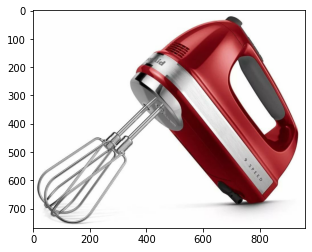

similar images: 
0.13819432394955067


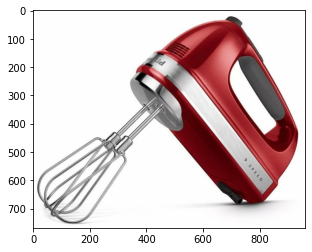

0.36117828674692753


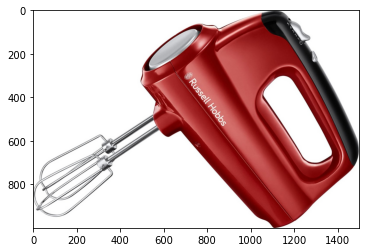

0.38282627423181814


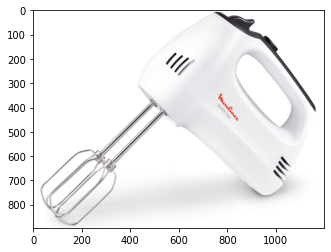

0.49458980142092424


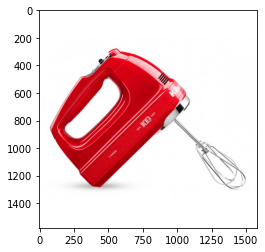

0.4989798313472278


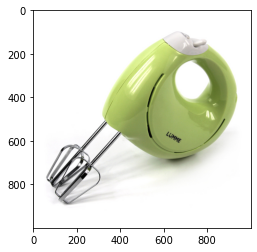

0.5664114511700907


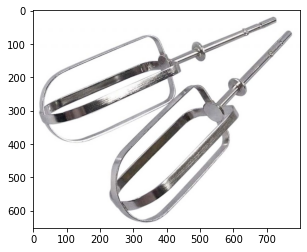

In [40]:
URL = 'https://avatars.mds.yandex.net/get-pdb/2062405/55ab37ca-d2f8-4496-9f2d-74cf83b6dcdd/s1200?webp=false' 
find_similar(URL, 'data_start', vecs, n_imgs = 6)

Специально загрузил такое же изображение, которое уже было в нашем датасете. Получили на выходе сначала такое же изображение (поскольку сам таргет также присутствует в датасете). Затем другой красный миксер в таком же положении, затем миксер другого цвета, который находился в таком же положении и был похож по форме на таргет, затем ещё один красный миксер, который находился в другом положении, а затем уже венчики. Т.е. алгоритм довольно хорошо справился со всеми паттернами: форма, цвет, положение на картинке, некоторые детали (венчики). Попробуем поискать мобильные телефоны:

selected image: 


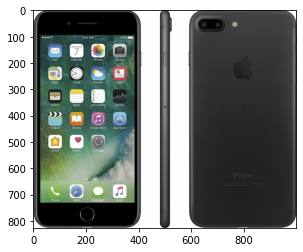

similar images: 
0.242490211394349


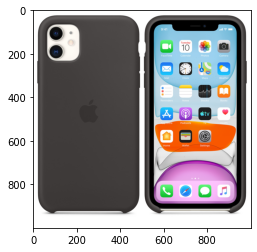

0.37999542785757623


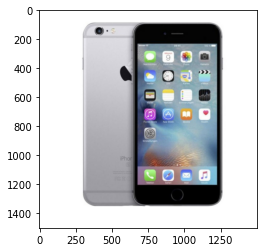

0.45137099906245615


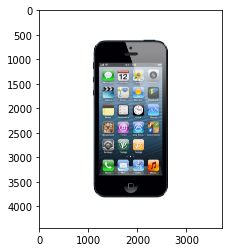

0.4689518620484845


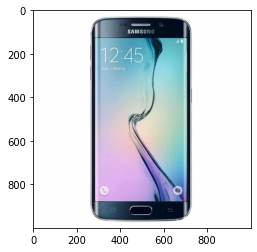

0.4842444407286052


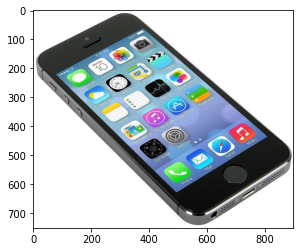

0.6538682452946121


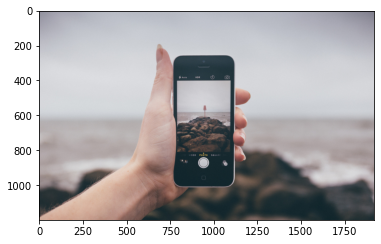

0.745608150799348


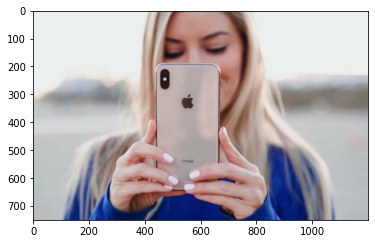

In [41]:
URL = 'https://avatars.mds.yandex.net/get-pdb/1689173/66814e2f-d2e6-4008-8143-5f88ae5e5cf5/s1200?webp=false'
find_similar(URL, 'data_start', vecs, n_imgs = 7)

Алгоритм вполне может находить телефон не только на белом фоне в таком же положении такого же цвета, но и на таких картинках, как последние, но уже хуже. (+0.18 по сравнению с телефоном на белом фоне)

selected image: 


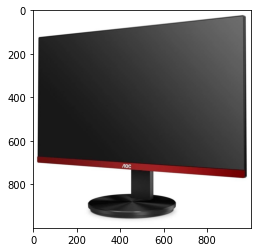

similar images: 
0.2785331774655897


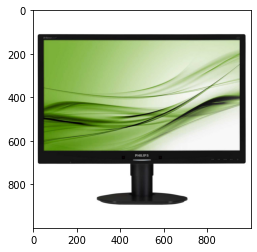

0.3135592431532983


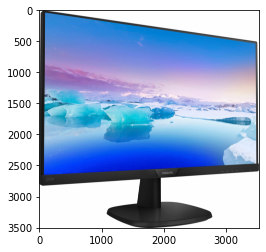

0.3377696982076215


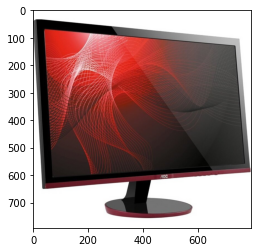

0.4120765636625101


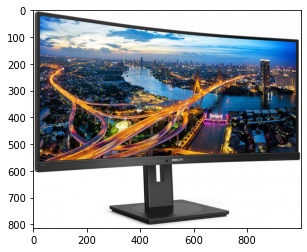

0.549080750872673


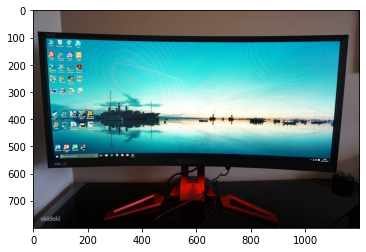

0.5972631415427776


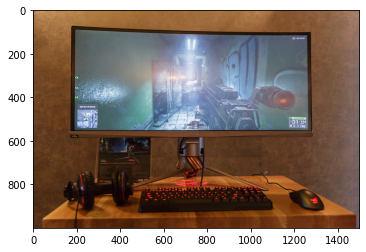

0.7143021651294698


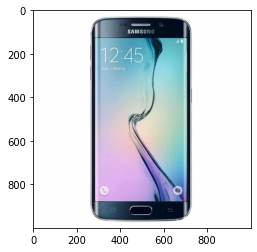

In [42]:
URL = 'https://cdn.segmentnext.com/wp-content/uploads/2019/03/AOC-G2590FX.jpg'
find_similar(URL, 'data_start', vecs, n_imgs = 7)

Всего в папке было 6 мониторов, все они найдены с точность до 0.6, телефон уже нашёлся с сильно бОльшим скором.

Теперь рассмотрим модель на датасете побольше (~1600 изображений настольных ламп)

In [ ]:
path = 'data_lamps'
vecs = imgs_to_vector(path, model, 16) 

selected image: 


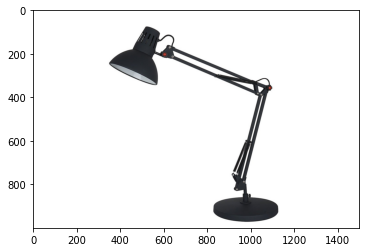

similar images: 
0.03312957077788481


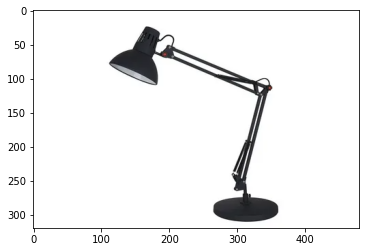

0.15699217329900916


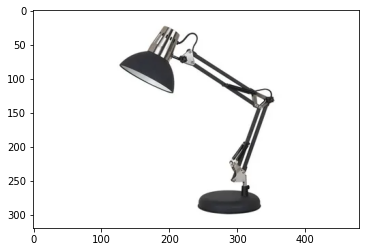

0.15699217329900916


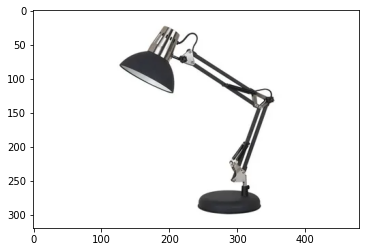

0.18635329189671723


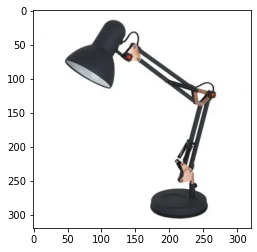

0.18716192153442268


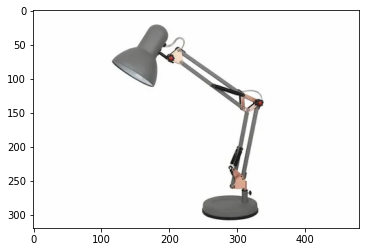

0.21207190920818508


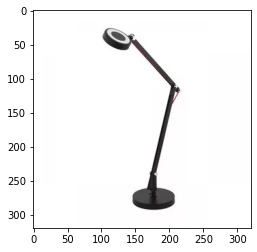

0.2202094544996307


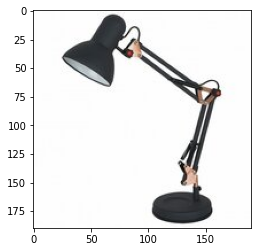

0.2210871585366777


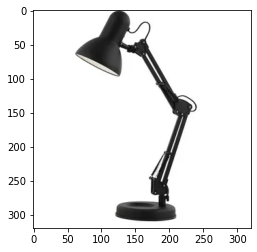

0.22199579198983876


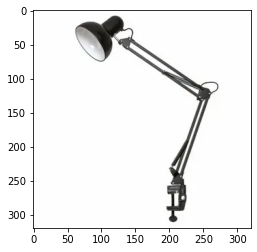

0.2297292880044326


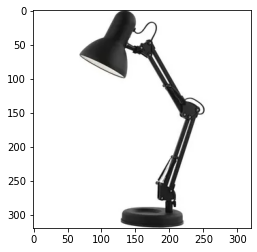

0.23916063277428168


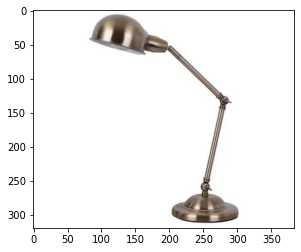

0.24930605249102022


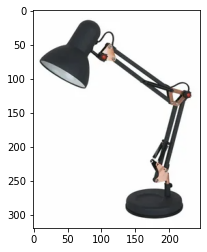

0.25610828580588185


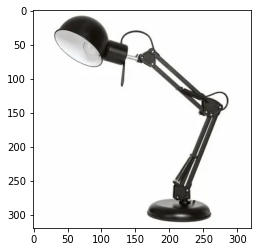

0.2567341994698631


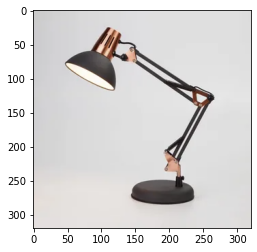

0.2596817989126612


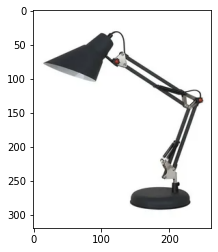

0.2653118499163446


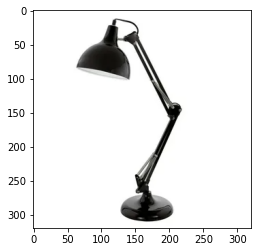

0.2692050869885898


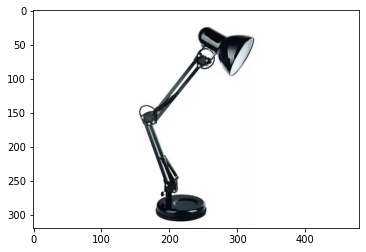

0.27026128696895635


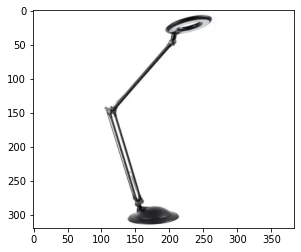

0.27026128696895635


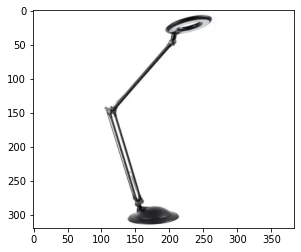

0.27026128696895635


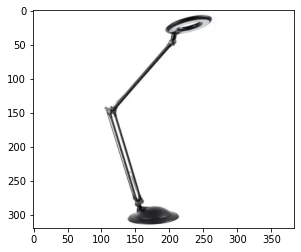

In [ ]:
URL = 'https://hoff.ru/upload/iblock/f25/f2561d717f8da6389dd9349dd6f04be0.jpg'
#'https://cdn.etm.ru/ipro/1325/tld553blackled400lm4500kdimusb.jpg'#'https://hoff.ru/upload/iblock/f25/f2561d717f8da6389dd9349dd6f04be0.jpg' # 'https://hoff.ru/upload/iblock/f25/f2561d717f8da6389dd9349dd6f04be0.jpg' #'https://lampa-online.com/upload/iblock/285/285ba492cfdcf706fee92e0bcabe983c.jpeg'
find_similar(URL, path, vecs, n_imgs = 20)

selected image: 


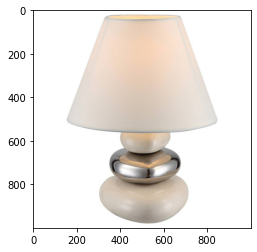

similar images: 
0.011621024578821526


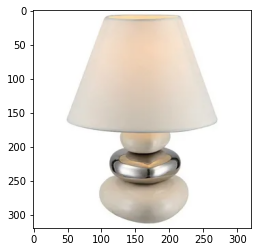

0.09217926633776508


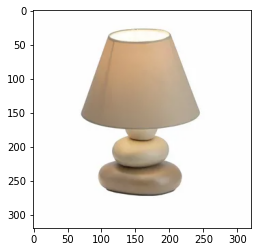

0.09584847612822556


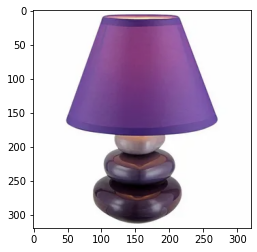

0.0986819963322838


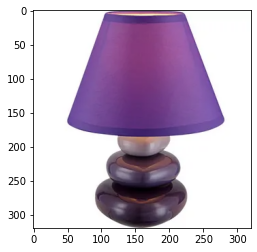

0.10889316115697256


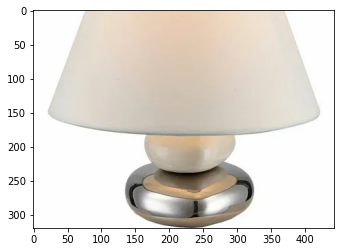

0.1314227626471688


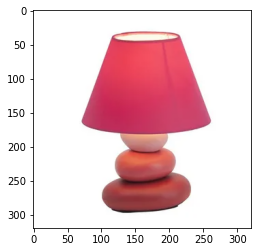

0.15200394685564722


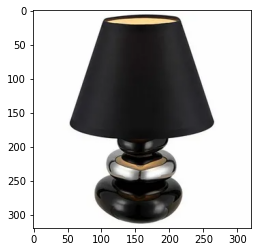

0.1595317723612797


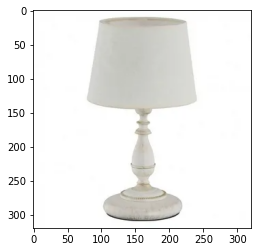

0.16439932211245645


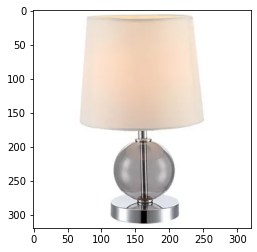

0.16992482600139902


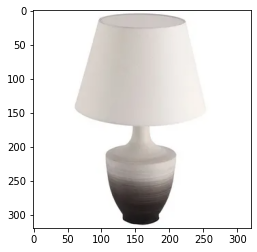

0.17077365096065766


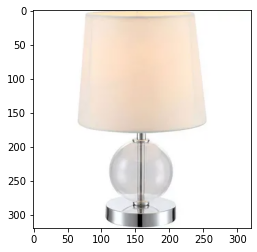

0.17231959655581552


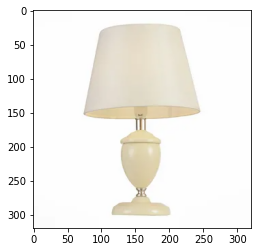

0.17231959655581552


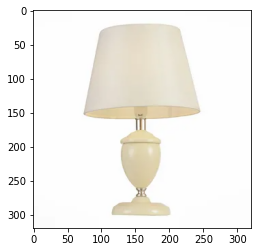

0.17231959655581552


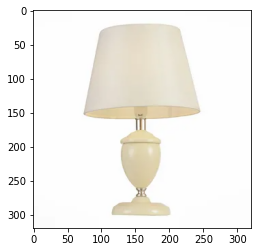

0.1734408645711465


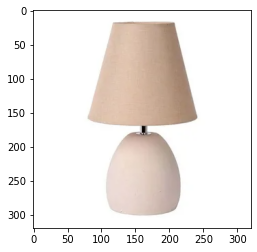

0.17808403566902586


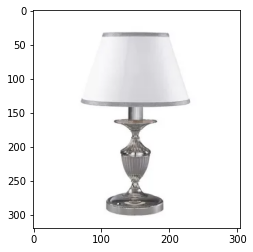

0.17808403566902586


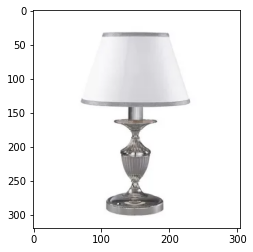

0.17808403566902586


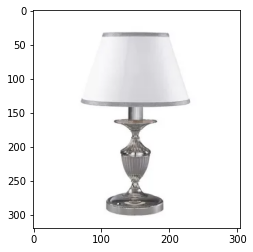

0.184058741911568


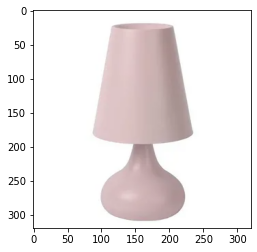

0.1855429339287522


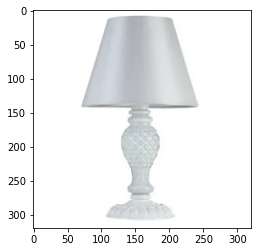

In [38]:
URL = 'https://lampa-online.com/upload/iblock/285/285ba492cfdcf706fee92e0bcabe983c.jpeg'
find_similar(URL, path, vecs, n_imgs = 20)